In [3]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from synthetic import causal_structure, linear_ts_data, calculate_metrics, calculate_aucroc, nonlinear_ts_data, simulate_lorenz_96, calculate_aucpr
from intervgc import igc
from train import train

In [4]:
device = torch.device('cuda')
GC, beta = causal_structure(p=5, beta_value=1.0, sparsity=0.5, seed=0)

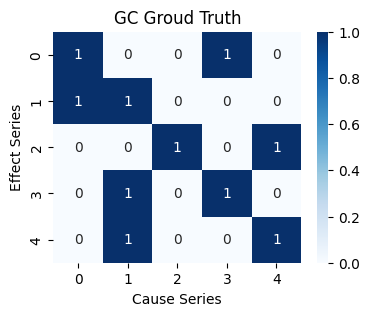

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))  # 1 row, 5 columns
sns.heatmap(GC, annot=True, cmap='Blues', ax=axs)
axs.set_title('GC Groud Truth')
axs.set_xlabel('Cause Series')
axs.set_ylabel('Effect Series')
plt.show()

In [6]:
env = 5
X = []

for index in range(env):
    data, interv_target, interv_beta = nonlinear_ts_data(T=1000, lag=1, beta=beta, GC=GC, seed=index+2, sd=0.1, interv=True, anomaly=500, strength=0.05)
    data_tensor = torch.tensor(data[np.newaxis], dtype=torch.float32, device=device)
    X.append(data_tensor)

In [13]:
model = igc(X[0].shape[-1], lag=1, hidden=[100], num_int=env).cuda(device=device)
train(model, X, elam=0.01, glam=0.06, lam_ridge=1e-2, lr=6e-2, max_iter=20000)

Iteration: 19 Loss tensor(2.6066, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.5951, 2.5421, 2.3772, 2.2868, 2.7242],
        [2.4848, 2.3826, 2.5327, 2.5535, 2.5322],
        [2.6717, 2.5321, 2.6113, 2.7077, 2.6116],
        [2.6777, 2.4750, 2.6692, 2.5530, 2.4812],
        [2.2951, 2.5559, 2.4939, 2.5390, 2.4365]], device='cuda:0',
       grad_fn=<StackBackward0>)
Iteration: 39 Loss tensor(2.5496, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.5703, 2.5129, 2.3480, 2.2607, 2.6932],
        [2.4583, 2.3606, 2.5036, 2.5254, 2.5036],
        [2.6397, 2.5031, 2.5840, 2.6784, 2.5845],
        [2.6475, 2.4492, 2.6375, 2.5264, 2.4529],
        [2.2678, 2.5275, 2.4665, 2.5115, 2.4098]], device='cuda:0',
       grad_fn=<StackBackward0>)
Iteration: 59 Loss tensor(2.5024, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.5440, 2.4838, 2.3190, 2.2348, 2.6623],
        [2.4317, 2.3378, 2.4747, 2.4962, 2.4743],
        [2.6071, 2.4740, 2.5577, 2.6482, 2.5583],
        [2.6166, 2.4235

In [14]:
GC_est = model.gc(threshold=False).cpu().data.numpy()
IF_est = model.itf(threshold=False)

In [15]:
GC_binary_est = model.gc(threshold=True).cpu().data.numpy()

precision, accuracy, recall, f1, shd = calculate_metrics(GC_binary_est, GC)
auc_roc = calculate_aucroc(GC_est, GC)
auc_pr = calculate_aucpr(GC_est, GC)

print(f"Pre: {precision}, Acc: {accuracy}, Recall {recall}, F1 Score: {f1}, SHD: {shd}, AUCROC: {auc_roc}, , AUCPR: {auc_pr}")

Pre: 1.0, Acc: 1.0, Recall 1.0, F1 Score: 1.0, SHD: 0, AUCROC: 1.0, , AUCPR: 0.9999999999999999


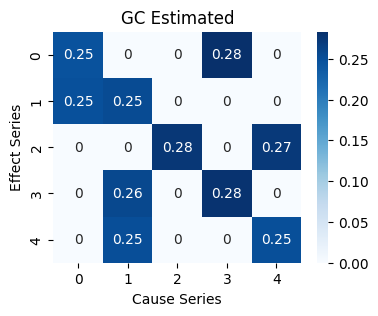

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))  # 1 row, 5 columns
sns.heatmap(GC_est, annot=True, cmap='Blues', ax=axs)
axs.set_title('GC Estimated')
axs.set_xlabel('Cause Series')
axs.set_ylabel('Effect Series')
plt.show()

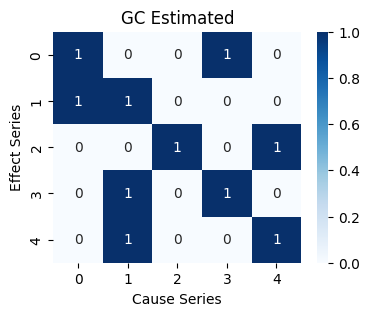

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(4, 3))  # 1 row, 5 columns
sns.heatmap(GC_binary_est, annot=True, cmap='Blues', ax=axs)
axs.set_title('GC Estimated')
axs.set_xlabel('Cause Series')
axs.set_ylabel('Effect Series')
plt.show()

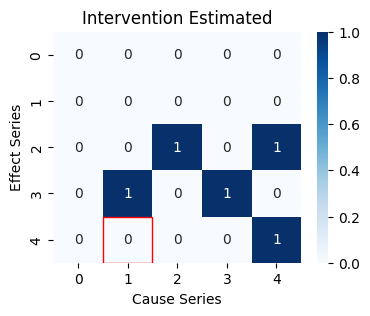

In [34]:
threshold = 3e-3
fig, axs = plt.subplots(1, 1, figsize=(4, 3))  # 1 row, 5 columns
sns.heatmap(IF_est[2].detach().cpu().numpy() > threshold, annot=True, cmap='Blues', ax=axs)
axs.set_title('Intervention Estimated')
axs.set_xlabel('Cause Series')
axs.set_ylabel('Effect Series')
rect = Rectangle((1, 4), 1, 1, fill=False, edgecolor='red', lw=1)
axs.add_patch(rect)
plt.show()